In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import requests 
%matplotlib inline
sess = tf.Session()

In [8]:
#load data
birthdata_url = 'http://springer.bme.gatech.edu/Ch17.Logistic/Logisticdat/lowbwt.dat'
birth_file = requests.get(birthdata_url)
birth_data = birth_file.text.split('\r\n')[5:]
birth_header = [x for x in birth_data[0].split(' ') if len(x)>=1]
birth_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
# Pull out target variable
y_vals = np.array([x[1] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[2:9] for x in birth_data])

#split data
train_indices = np.array(np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False))
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [11]:
#normalize columns
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min)/(col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

/home/huzeyfekiran/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [34]:
#batch size and placeholders 
batch_size = 100
x_data = tf.placeholder(dtype=tf.float32, shape=[None,7])
y_target = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [35]:
#We will declare functions that initialize a variable and a layer in our model. To create a better logistic funciton,
#we need to create a function that returns a logistic layer on an input layer. In other words, we will just use
#a fully connected layer and return a sigmoid element-wise for each layer. It is important to remember that our loss
#function will have the final sigmoid included, so we want to specify on our last layer that we will not return the 
#sigmoid of the output. 
def init_variable(shape):
    return(tf.Variable(tf.random_normal(shape=shape)))

#Create a logistic layer definition
def logistic(input_layer, multiplication_weight, bias_weight, activation=True):
    linear_layer = tf.add(tf.matmul(input_layer,multiplication_weight),bias_weight)
    
    if activation:
        return(tf.nn.sigmoid(linear_layer))
    else:
        return(linear_layer)

In [36]:
#Now we will declare three layers(2 hidden 1 output). We will start by initializing a weight and a bias matrix for 
#each layer and defining the layer operations

#First logistic layer (7 inputs to 14 hidden nodes)
A1 = init_variable([7,14])
b1 = init_variable([14])
logistic_layer1 = logistic(x_data, A1, b1)

#Second logistic layer (14 hidden inputs to 5 hidden nodes)
A2 = init_variable([14,5])
b2 = init_variable([5])
logistic_layer2 = logistic(logistic_layer1, A2, b2)

#Final logistic layer (5 hidden inputs to 1 output)
A3 = init_variable([5,1])
b3 = init_variable([1])
final_output = logistic(logistic_layer2, A3, b3)

In [37]:
#Loss function and optimizer
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=final_output, logits=y_target))
opt = tf.train.AdamOptimizer(0.002)
train_step = opt.minimize(loss)

#Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [38]:
#Create a prediction and accuracy operation on the graph.
prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [39]:
#Train for 1500 generations and save the model loss and train/test accuracies.
loss_vec = []
train_acc = []
test_acc = []

for i in range(1500):
    #Select random indices for batch selection
    rand_index = np.random.choice(len(x_vals_train),batch_size)
    #Select batch
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    #Run the training step
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    #Get training loss
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    #Get training accuracy
    temp_acc_train = sess.run(accuracy, feed_dict={x_data:x_vals_train, y_target:np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    #Get test accuracy
    temp_acc_test = sess.run(accuracy, feed_dict={x_data:x_vals_test, y_target:np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    
    if(i+1)%150==0:
        print('Loss = ' + str(temp_loss))

Loss = 0.60309756
Loss = 0.56833947
Loss = 0.58226246
Loss = 0.5840093
Loss = 0.5533777
Loss = 0.5968291
Loss = 0.5888417
Loss = 0.5809024
Loss = 0.5917728
Loss = 0.60275185


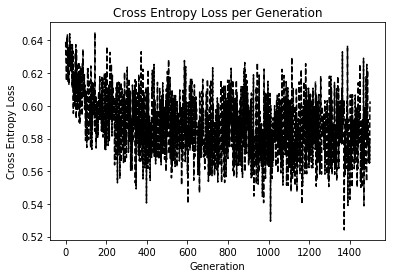

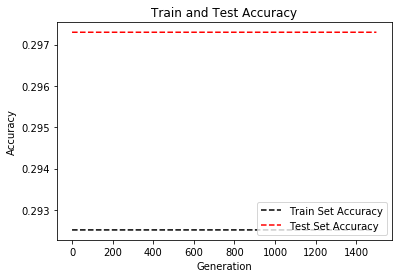

In [40]:
#Plot loss over time
plt.plot(loss_vec, 'k--')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()
#Plot train and test accuracy
plt.plot(train_acc, 'k--', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()